In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.style.use('ggplot')

# Dataset overview

In [4]:
df = pd.read_pickle("data/preprocessed/collaborative_df.pkl")
df.sample(10)

,user_id,recipe_name,rating
803920,62878,1241,5
1423604,110821,1722,6
1732063,134988,658,5
462437,36899,1975,5
1612009,124694,1649,5
1082936,83557,154,5
241091,19353,1663,5
1544795,119215,1665,5
2200281,171732,454,5
56109,4553,1645,5


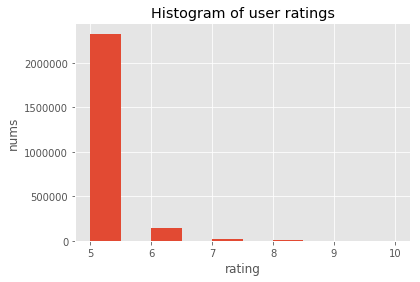

In [5]:
df.rating.hist()
plt.xlabel("rating")
plt.ylabel("nums")
plt.title("Histogram of user ratings");

In [6]:
print(f"Our dataset have {df.user_id.max()} unique users' favorite {len(df)} recipes in total.")
print(f"Recipes are mapped within {len(df.recipe_name.unique())} categories.")
print(f"User ratings are shown above, mean value is {df.rating.mean()}, maximum is {df.rating.max()}.")

Our dataset have 198816 unique users' favorite 2511218 recipes in total.
Recipes are mapped within 1628 categories.
User ratings are shown above, mean value is 5.091716051732665, maximum is 10.


In [7]:
from surprise import dump
from surprise.accuracy import rmse
from collab_filter import load_trained_pred_algo

# NMF algorithm 

*\*baseline*

In [8]:
df_nmf_dev, predictions_nmf_dev, algo_nmf = load_trained_pred_algo('models/dump_NMF_dev')
df_nmf_test, predictions_nmf_test, _ = load_trained_pred_algo('models/dump_NMF_test')

# SVD algorithm

In [9]:
df_svd_dev, predictions_svd_dev, algo_svd = load_trained_pred_algo('models/dump_SVD_dev')
df_svd_test, predictions_svd_test, _ = load_trained_pred_algo('models/dump_SVD_test')

## Compare with NMF

### RMSE

In [10]:
print(f"Dev\n{'='*20}")
print("SVD |", end=" "); rmse(predictions_svd_dev);
print("NMF |", end=" "); rmse(predictions_nmf_dev);

Dev
SVD | RMSE: 0.3317
NMF | RMSE: 0.4574


In [11]:
print(f"Test\n{'='*20}")
print("SVD |", end=" "); rmse(predictions_svd_test);
print("NMF |", end=" "); rmse(predictions_nmf_test);

Test
SVD | RMSE: 0.3634
NMF | RMSE: 0.5851


### Recall

We define the **miss** as if the recipe error of $(true - estimation) > 0.05$.<br>
Since the rating feature actually represents the binary favor (like or not like), rather than measurement of some recipes.<br>
So the estimation is quite close, as you can see in the above figure, errors are mainly distributed in range $[0,\ 1]$.<br>
Therefore, we have to choose relatively small error to calculate **recall**, which means the number of the predicted most-like recipes over the number of true right recipes, i.e., $$\frac{TP}{TP + FN}$$ where $TP=true\ positive$ and $FN=false\ negative$

In [12]:
from collab_filter import cal_recall
ERROR_THRESHOLD = 0.05

In [13]:
recall_svd_dev = cal_recall(predictions_svd_dev, ERROR_THRESHOLD)
recall_nmf_dev = cal_recall(predictions_nmf_dev, ERROR_THRESHOLD)
recall_svd_test = cal_recall(predictions_svd_test, ERROR_THRESHOLD)
recall_nmf_test = cal_recall(predictions_nmf_test, ERROR_THRESHOLD)

In [14]:
def show_recall(recall_list):
    return np.array(list(recall_list.values())).mean()

In [15]:
print(f"Dev\n{'='*20}")
print(f"SVD | Recall: {show_recall(recall_svd_dev):.4f}");  
print(f"NMF | Recall: {show_recall(recall_nmf_dev):.4f}");  

Dev
SVD | Recall: 0.9173
NMF | Recall: 0.5081


In [16]:
print(f"Test\n{'='*20}")
print(f"SVD | Recall: {show_recall(recall_svd_test):.4f}");  
print(f"NMF | Recall: {show_recall(recall_nmf_test):.4f}");  

Test
SVD | Recall: 0.9301
NMF | Recall: 0.5393


### Prediction

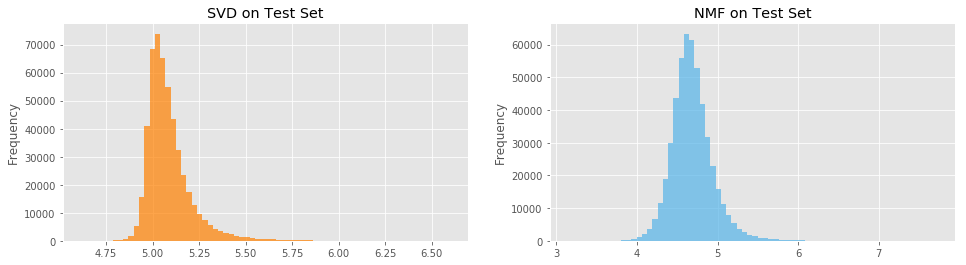

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_svd_test.estimation.plot(ax=ax1, kind='hist', bins=70, title='SVD on Test Set', color="#FF8000", alpha=0.7, label="Prediction");
df_nmf_test.estimation.plot(ax=ax2, kind='hist', bins=70, title='NMF on Test Set', color="#56B4E9", alpha=0.7, label="Prediction");

## Error analysis of SVD

In [18]:
df_svd_test['err'] = abs(df_svd_test.estimation - df_svd_test.rating)
df_svd_test.sample(10)

,user_id,item_id,rating,estimation,err
133669,49083,1728,6.0,5.403980,0.596020
445413,33703,269,5.0,5.045656,0.045656
227755,75047,127,5.0,4.974601,0.025399
365637,88677,33,5.0,4.971854,0.028146
39619,114348,2,5.0,5.154120,0.154120
105015,159731,1172,5.0,5.156064,0.156064
283357,186685,1984,6.0,5.213806,0.786194
336877,26264,156,5.0,5.112621,0.112621
160469,41595,627,5.0,5.021005,0.021005
250629,114264,1470,5.0,5.085796,0.085796


In [19]:
best_predictions = df_svd_test.sort_values(by='err')[:10]
worst_predictions = df_svd_test.sort_values(by='err')[-10:]

Prediction with the smallest error

In [20]:
best_predictions

,user_id,item_id,rating,estimation,err
112542,40465,1346,5.0,5.000000,3.124685e-07
418962,159378,688,5.0,5.000000,4.134485e-07
209856,62736,1177,5.0,5.000000,4.762914e-07
457017,189065,753,5.0,5.000001,6.925932e-07
11018,104297,1876,5.0,5.000001,8.111332e-07
158020,51646,198,5.0,5.000001,8.310324e-07
90943,126586,518,5.0,4.999999,1.085015e-06
180816,146376,1484,5.0,4.999999,1.098866e-06
477697,53147,1781,5.0,4.999999,1.129032e-06
361707,109460,1254,5.0,4.999999,1.235163e-06


Prediction with the biggest error

In [21]:
worst_predictions

,user_id,item_id,rating,estimation,err
491784,148668,1758,10.0,5.022196,4.977804
299182,104665,1277,10.0,5.010881,4.989119
102153,193426,1177,10.0,5.006700,4.993300
419501,154849,18,10.0,4.997753,5.002247
488257,87937,1714,10.0,4.992801,5.007199
43822,51405,1793,10.0,4.991969,5.008031
286824,108821,1739,10.0,4.989517,5.010483
221413,66025,136,10.0,4.933310,5.066690
121797,143951,1998,10.0,4.877748,5.122252
114665,54347,1844,10.0,4.865435,5.134565


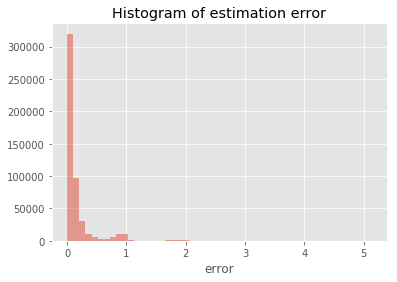

In [22]:
df_svd_test['err'].hist(bins=50, alpha=0.5)
plt.xlabel("error")
plt.title("Histogram of estimation error");

## Recommendations

In [23]:
import json
from collab_filter import top_k
from pathlib import Path

In [24]:
top_5 = top_k(predictions_svd_test, 5)
dictionary = json.load(Path("data/preprocessed/dictionary.json").open(encoding="utf-8"))

In [25]:
recipe_id_to_english = {ind: v for ind, (k, v) in enumerate(dictionary.items())}

In [26]:
def display_recommend(data, dictionary, ind=None):
    if ind is None:
        ind = np.random.randint(0, high=len(data))
    try:
        print(f"Recommendation for user [{ind}]")
        for recipe_id, rates in data[ind]:
            print(f"·{dictionary[recipe_id]}: {rates:.3f}")
    except KeyError:
        print(f"User {ind} doesn't exist.")

In [27]:
display_recommend(top_5, recipe_id_to_english)

Recommendation for user [36632]
·Scrambled Egg with Scallion: 5.012
·Crab Shells Stuffed with Cheese: 5.007


## *Appendix: Grid search*

In [28]:
from collab_filter import load_dataset
from surprise import SVD
from surprise.model_selection import GridSearchCV, KFold

In [29]:
def train_grid_search():
    data = load_dataset()
    param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all' : [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    table = [[] for _ in range(len(gs.cv_results['params']))]
    for i in range(len(gs.cv_results['params'])):
        for key in gs.cv_results.keys():
            table[i].append(gs.cv_results[key][i])
    headers = gs.cv_results.keys()
    return pd.DataFrame(table, columns=headers, index=gs.cv_results["params"])

In [30]:
csv_path = Path("res/svd_grid_serach.csv")
if csv_path.exists():
    df = pd.read_csv(str(csv_path), index_col=0)
else:
    df = train_grid_search()
    df.to_csv(str(csv_path))

In [31]:
# Remove repeated columns for better 
pd.options.display.float_format = '{:.4f}'.format
df.index.rename('params', inplace=True)
df.drop([h for h in df.head() if h .startswith("param")], axis=1)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time
params,,,,,,,,,,,,,,,,
"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",0.3644,0.3609,0.3628,0.3627,0.0014,6,0.1582,0.1577,0.1582,0.1580,0.0002,4,29.4713,0.0564,8.9317,0.0898
"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",0.3650,0.3614,0.3634,0.3633,0.0014,8,0.1593,0.1588,0.1594,0.1592,0.0003,7,28.8231,0.1532,8.8813,0.0402
"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",0.3638,0.3603,0.3620,0.3620,0.0014,2,0.1573,0.1568,0.1581,0.1574,0.0005,1,29.3047,0.7659,9.3364,0.7014
"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",0.3645,0.3609,0.3626,0.3627,0.0015,5,0.1587,0.1582,0.1595,0.1588,0.0005,6,29.8173,0.9193,9.6570,1.1730
"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",0.3637,0.3601,0.3621,0.3620,0.0014,1,0.1581,0.1575,0.1580,0.1579,0.0002,3,56.7222,0.0553,9.3279,0.6558
"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.6}",0.3644,0.3608,0.3628,0.3626,0.0014,4,0.1594,0.1588,0.1594,0.1592,0.0003,8,56.8888,0.2027,8.9146,0.0008
"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",0.3641,0.3605,0.3623,0.3623,0.0015,3,0.1574,0.1570,0.1582,0.1575,0.0005,2,56.7971,0.1359,8.8146,0.0142
"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}",0.3647,0.3611,0.3629,0.3629,0.0015,7,0.1585,0.1581,0.1593,0.1586,0.0005,5,56.8352,0.1780,9.3248,0.6603
